In [48]:
import os
import pandas as pd
import nltk
import numpy as np
import pandas as pd
import seaborn as sns
import regex
import string
import unicodedata
import matplotlib.pyplot as plt

In [11]:
import nltk
from nltk import WordNetLemmatizer
from nltk import sent_tokenize
from nltk import pos_tag
from nltk.corpus import wordnet as wn
from nltk.corpus import stopwords
from nltk.sentiment.util import  mark_negation
from nltk.tokenize import TweetTokenizer
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


True

In [42]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report as clsr
from sklearn.metrics import confusion_matrix, cohen_kappa_score, plot_confusion_matrix
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split

In [4]:
!pip install transformers

In [5]:
import torch
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
#from torchtext import data
from transformers import BertForSequenceClassification, AdamW, BertConfig
from transformers import BertTokenizer
from keras.preprocessing.sequence import pad_sequences

In [6]:
## Read the Data
DF_ = pd.read_csv('Steam_Clean_Data.csv')
DF_.head()

,review,recommendation,authentic
0,gt played as german reich gt declare war on b...,Recommended,TRUE
1,very good game although a bit overpriced in my...,Recommended,TRUE
2,out of all the reviews i wrote this one is pro...,Recommended,TRUE
3,disclaimer i survivor main i play games for fu...,Recommended,TRUE
4,english after playing for more than two years ...,Recommended,TRUE


In [7]:
DF, _ = train_test_split(DF_, train_size = 5000, stratify=DF_['recommendation'], random_state = 580)

In [8]:
DF.reset_index(drop = True)

,review,recommendation,authentic
0,would die naked by bear mauling again,Recommended,SUSPEND
1,found a man he gave me a gun then i shot him,Recommended,TRUE
2,great game and one that i don t mind playing i...,Recommended,TRUE
3,this game never gets boring if you are a frien...,Recommended,TRUE
4,good game very fun just takes hours to load in...,Recommended,FALSE
...,...,...,...
4995,the recent updates have made what would have t...,Not Recommended,SUSPEND
4996,this game is in early access and it is awesome...,Recommended,SUSPEND
4997,very fun game with friends or even alone you w...,Recommended,SUSPEND
4998,the game is absolute trash like the people are...,Not Recommended,TRUE


Now we have the row dataframe that we wanted, with those attributes(hotel name, sentiment polarity, resource, review and a label(authenticity))! We can move the next step which is cleaning and tokenizing data.

## Cleaning and Tokenizing

We need to build a preprocessor first tokenize the reviews.

In [12]:
class Preprocessor(BaseEstimator, TransformerMixin):


    def __init__(self, lower=True, strip=True, remove_punct=True, 
                 remove_diacritics=True, unicode_form='NFC', 
                 remove_stop=False, stem_tokens=False, 
                 lemmatize_tokens=True, language='english'):
        
        self.lower      = lower
        self.strip      = strip
        self.remove_punct = remove_punct
        self.remove_diacritics = remove_diacritics
        self.set_unicode_form(unicode_form)
     
        self.remove_stop = remove_stop
        self.stem_tokens = stem_tokens
        self.lemmatize_tokens = lemmatize_tokens    

        self.stopwords  = set(nltk.corpus.stopwords.words(language))
        self.punct      = set(string.punctuation)

        self.lemmatizer = WordNetLemmatizer()
        self.stemmer = nltk.stem.SnowballStemmer(language) 
        self.tokenizer = TweetTokenizer()

 
    def transform(self, X):
        return [
            list(self.tokenize(doc)) for doc in X
        ]

    def inverse_transform(self, X):
        return [" ".join(doc) for doc in X]


    def fit(self, X, y=None):
        return self

 
    def set_stopwords(self, stopwords):
        self.stopwords  = stopwords or set(nltk.corpus.stopwords.words('english'))


    def set_punct(self, punct):
        self.punct      = punct or set(string.punctuation)


    def set_unicode_form(self, unicode_form):
        self.unicode_form = unicode_form.strip().upper()
        if not self.unicode_form in ['NFC','NFD','NFKC','NFKD']:
            self.unicode_form = 'NFC'


    def show_settings(self):
        print("lower: ",self.lower)
        print("strip: ",self.strip)
        print("remove_punct: ",self.remove_punct)
        print("remove_diacritics: ",self.remove_diacritics)
        print("unicode_form: ",self.unicode_form)
        print("remove_stop: ",self.remove_stop)
        print("stem_tokens: ",self.stem_tokens)
        print("lemmatize_tokens",self.lemmatize_tokens)       
        print("lemmatizer: ",type(self.lemmatizer).__name__)
        print("stemmer: ",type(self.stemmer).__name__) 
        print("punctuation: ",self.punct)
        print("stopwords: ",self.stopwords)


    # convert nltk pos-tag to wordnet pos-tag
    # for use by the wordnet lemmatizer
    @staticmethod
    def get_wordnet_tag(nltk_tag):
        if nltk_tag.startswith('N'):
            return wn.NOUN
        elif nltk_tag.startswith('V'):
            return wn.VERB
        elif nltk_tag.startswith('J'):
            return wn.ADJ
        elif nltk_tag.startswith('R'):
            return wn.ADV
        else:          
            return None

    # determine whether a string is comprised of all punctuation-like characters
    def is_punct(self, text):
        if text in self.punctuation:
            return True
        if regex.match(r"[\p{P}\p{Mn}\p{Sk}]+", text):
            return True
        return False


    # normalize token strings
    def normalize_string(self, token):

        token = html.unescape(token)
        token = token.lower() if self.lower else token
        token = token.strip(' _*')  if self.strip else token

        if self.remove_diacritics:
            token = regex.sub("\p{Mn}",'',unicodedata.normalize('NFD',token)) 

        #not is in the stopword list, but n't isn'
        if token == "n't" and self.stopwords:
            token = "not"
      
        return unicodedata.normalize(self.unicode_form,token)

    # determine whether a string is comprised completely
    # of things that seem like punctuation
    def is_punct(self, text):
        if text in string.punctuation:
            return True
        if regex.match(r"^[\p{P}\p{Mn}\p{Sk}]+$", text):
            return True
        return False

    # tokenize the document with optional normalization
    def tokenize(self, document, all_fields=False):
        tokens = []
        for sent in sent_tokenize(document):
            cleaner_sent = html.unescape(sent)
            for token in nltk.pos_tag(self.tokenizer.tokenize(cleaner_sent)):
                stem = ''
                token_text = self.normalize_string(token[0])
                token_pos = token[1]
                if self.remove_punct and self.is_punct(token_text):
                #if remove_punct and token_text in string.punctuation:
                    continue
                if self.remove_stop and token_text in self.stopwords:
                    continue
                if self.stem_tokens or all_fields:
                    stem = self.stemmer.stem(token_text)
                if self.lemmatize_tokens or all_fields:
                    wordnet_tag = self.get_wordnet_tag(token_pos)
                    if wordnet_tag is not None:
                        lemma = self.lemmatizer.lemmatize(token_text,wordnet_tag)
                    else:
                        lemma = token_text
                if all_fields:
                    tokens.append({'token': token_text, 'stem': stem, 'lemma': lemma})
                elif self.stem_tokens:
                    tokens.append(stem)
                elif self.lemmatize_tokens:
                    tokens.append(lemma)
                else:
                    tokens.append(token_text)     
        return tokens

Now we will use the preprocessor to tokenize the reviews

In [13]:
my_preprocessor = Preprocessor(remove_punct=True, remove_stop=True, lemmatize_tokens=True)
DF['review']=DF['review'].apply(my_preprocessor.tokenize)
DF.head()

,review,recommendation,authentic
323924,"[would, die, naked, bear, mauling]",Recommended,SUSPEND
287970,"[find, man, give, gun, shot]",Recommended,TRUE
319657,"[great, game, one, mind, playing, first, perso...",Recommended,TRUE
57843,"[game, never, get, boring, friend, soccer, car...",Recommended,TRUE
280789,"[good, game, fun, take, hour, load, without, s...",Recommended,FALSE


Let's check the data type of the columns in this dataframe

In [14]:
DF.dtypes

review            object
recommendation    object
authentic         object
dtype: object

We need to change our label to category type

In [15]:
DF['recommendation']=DF['recommendation'].astype('category')
DF['authentic']=DF['authentic'].astype('category')

Before we split the dataframe into train and test data, I will save it to a csv file firstly.

In [16]:
DF.to_csv('DF_Tokenize.csv',header=True,index=False)

## Prepare training and test data

In [17]:
DF = pd.read_csv('DF_Tokenize.csv')

In [18]:
DF.head()

,review,recommendation,authentic
0,"['would', 'die', 'naked', 'bear', 'mauling']",Recommended,SUSPEND
1,"['find', 'man', 'give', 'gun', 'shot']",Recommended,TRUE
2,"['great', 'game', 'one', 'mind', 'playing', 'f...",Recommended,TRUE
3,"['game', 'never', 'get', 'boring', 'friend', '...",Recommended,TRUE
4,"['good', 'game', 'fun', 'take', 'hour', 'load'...",Recommended,FALSE


In [19]:
DF['review'] = DF['review'].apply(lambda x: ' '.join(eval(x)))

# Bert

In [20]:
texts=DF['review']
labels=DF['recommendation']

In [21]:
label_to_index = {}
index_to_label = {}
label_lst = list(set(labels))
for i in range(len(label_lst)):
    label = label_lst[i]
    label_to_index[label] = i
    index_to_label[i] = label

In [22]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/455k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [23]:
input_ids = []
for text in texts:
    encoded_sent = tokenizer.encode(text,
                                    add_special_tokens=True, 
                                    max_length=128,
                                    truncation=True)
    input_ids.append(encoded_sent)

In [24]:
print('Max sentence length: ', max([len(sent) for sent in input_ids]))

Max sentence length:  128


In [25]:
input_ids = pad_sequences(input_ids, maxlen=128, dtype="long", 
                          value=0, truncating="post", padding="post")

In [26]:
attention_masks = []
for sent in input_ids:
    att_mask = [int(token_id > 0) for token_id in sent]
    attention_masks.append(att_mask)

In [27]:
labels = [label_to_index[label] for label in labels]

In [28]:
train_input_ids, test_input_ids, train_labels, test_labels \
    = train_test_split(input_ids, labels, test_size=0.3, random_state=42)

train_attention_masks, test_attention_masks, train_labels, test_labels \
    = train_test_split(attention_masks, labels, test_size=0.3, random_state=42)

In [29]:
train_input_ids = torch.tensor(train_input_ids)
test_input_ids = torch.tensor(test_input_ids)

train_labels = torch.tensor(train_labels)
test_labels = torch.tensor(test_labels)

train_attention_masks = torch.tensor(train_attention_masks)
test_attention_masks = torch.tensor(test_attention_masks)

In [30]:
batch_size = 32
# Create the DataLoader for our training set.
train_data = TensorDataset(train_input_ids, train_attention_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

# Create the DataLoader for our test set.
test_data = TensorDataset(test_input_ids, test_attention_masks, test_labels)
test_sampler = SequentialSampler(test_data)
test_dataloader = DataLoader(test_data, sampler=test_sampler, batch_size=batch_size)

In [32]:
model = BertForSequenceClassification.from_pretrained(
    "bert-base-uncased", 
    num_labels = len(label_lst),  
    output_attentions = False, 
    output_hidden_states = False
)
model.cuda()

Downloading:   0%|          | 0.00/420M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

In [34]:
if torch.cuda.is_available():       
    device = torch.device("cuda")
    print('There are %d GPU(s) available.' % torch.cuda.device_count())
    print('We will use the GPU')
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
We will use the GPU


In [35]:
optimizer = AdamW(model.parameters(),
                  lr = 2e-5,
                  eps = 1e-8)

In [36]:
for epoch_i in range(10):
    print("")
    print('Epoch {}'.format(epoch_i + 1))
    print('Training...')
    
    total_loss = 0
    model.train()
    for batch in train_dataloader:
        batch = tuple(t.to(device) for t in batch)
        b_input_ids, b_input_mask, b_labels = batch
        
        model.zero_grad()
        outputs = model(b_input_ids, 
                    token_type_ids=None, 
                    attention_mask=b_input_mask, 
                    labels=b_labels)
        loss = outputs[0]
        total_loss += loss.item()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        
    avg_train_loss = total_loss / len(train_dataloader)
    print("Average training loss: {0:.2f}".format(avg_train_loss))


Epoch 1
Training...
Average training loss: 0.50

Epoch 2
Training...
Average training loss: 0.36

Epoch 3
Training...
Average training loss: 0.25

Epoch 4
Training...
Average training loss: 0.16

Epoch 5
Training...
Average training loss: 0.10

Epoch 6
Training...
Average training loss: 0.07

Epoch 7
Training...
Average training loss: 0.05

Epoch 8
Training...
Average training loss: 0.04

Epoch 9
Training...
Average training loss: 0.04

Epoch 10
Training...
Average training loss: 0.03


In [37]:
model.eval()
preds_test = []
labels_test = []
for batch in test_dataloader:
    batch = tuple(t.to(device) for t in batch)
    b_input_ids, b_input_mask, b_labels = batch
    with torch.no_grad():
        outputs = model(b_input_ids, 
                        token_type_ids=None, 
                        attention_mask=b_input_mask)
    logits = outputs[0]
    logits = logits.detach().cpu().numpy()
    label_ids = b_labels.to('cpu').numpy()

    preds_flat = np.argmax(logits, axis=1).flatten()
    labels_flat = label_ids.flatten()
    
    preds_test += list(preds_flat)
    labels_test += list(labels_flat)

In [38]:
print("Accuracy:", accuracy_score(labels_test, preds_test))
print("Precision:", precision_score(labels_test, preds_test, average="macro"))
print("Recall:", recall_score(labels_test, preds_test, average="macro"))
print("Macro F1:", f1_score(labels_test, preds_test, average="macro"))

Accuracy: 0.804
Precision: 0.7890822005542181
Recall: 0.7681346667738438
Macro F1: 0.7762802249981737


In [40]:
labels_test_txt = list(map(lambda x: index_to_label[x], labels_test))
preds_test_txt = list(map(lambda x: index_to_label[x], preds_test))
cnf_matrix = confusion_matrix(labels_test_txt, preds_test_txt, labels=['Recommended', 'Not Recommended'])

Text(91.68, 0.5, 'predicted label')

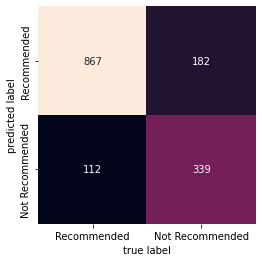

In [50]:
plt.grid(False)
#mat = confusion_matrix(y_test, nb_labels, labels=['Extremely Popular', 'Very Popular'])

#plt.figure(figsize=(10, 8))
sns.heatmap(cnf_matrix.T, square=True, annot=True, fmt='d', cbar=False,
            xticklabels=['Recommended', 'Not Recommended'],
            yticklabels=['Recommended', 'Not Recommended'])
plt.xlabel('true label')
plt.ylabel('predicted label')
#plt.savefig('reddit-nb-cm.png')

In [51]:
print(clsr(labels_test, preds_test, target_names=['Recommended', 'Not Recommended']))

                 precision    recall  f1-score   support

    Recommended       0.75      0.65      0.70       521
Not Recommended       0.83      0.89      0.86       979

       accuracy                           0.80      1500
      macro avg       0.79      0.77      0.78      1500
   weighted avg       0.80      0.80      0.80      1500



We also used BERT which is a transformer-based machine learning model for our classification problem. For BERT model, it is different from logistic regression. We pass in the textual data and BERT will tokenize the texts by inserting some tokens to indicate the start and end of the sentence. BERT will also use mask to separate different sentences. Each token will be mapped to a token id. Position embeddings are also added to indicate the position of each token. After tokenizing the input, the token ids as well as the attention masks will be fed into classifier.

## Conclusion

Based on the evaluation on the test set, we can observe that BERT model is slightly better than logistic regression and Naive Bayes, but not as good as SVM. This could be because that the dataset is not a complex task. For more complex tasks, BERT model can be expected to perform better. But overall, all the models we trained made pretty accurate predictions on this dataset.

In the future, we could improve by incorporating word2vec embeddings instead of using TF-IDF and
count vectorizers, or include more feature engineering techniques before modeling.